# Compact Convolutional Transformers

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/06/30<br>
**Last modified:** 2023/08/07<br>
**Description:** Compact Convolutional Transformers for efficient image classification.

As discussed in the [Vision Transformers (ViT)](https://arxiv.org/abs/2010.11929) paper,
a Transformer-based architecture for vision typically requires a larger dataset than
usual, as well as a longer pre-training schedule. [ImageNet-1k](http://imagenet.org/)
(which has about a million images) is considered to fall under the medium-sized data regime with
respect to ViTs. This is primarily because, unlike CNNs, ViTs (or a typical
Transformer-based architecture) do not have well-informed inductive biases (such as
convolutions for processing images). This begs the question: can't we combine the
benefits of convolution and the benefits of Transformers
in a single network architecture? These benefits include parameter-efficiency, and
self-attention to process long-range and global dependencies (interactions between
different regions in an image).

In [Escaping the Big Data Paradigm with Compact Transformers](https://arxiv.org/abs/2104.05704),
Hassani et al. present an approach for doing exactly this. They proposed the
**Compact Convolutional Transformer** (CCT) architecture. In this example, we will work on an
implementation of CCT and we will see how well it performs on the CIFAR-10 dataset.

If you are unfamiliar with the concept of self-attention or Transformers, you can read
[this chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11/r-3/312)
from  François Chollet's book *Deep Learning with Python*. This example uses
code snippets from another example,
[Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/).

## Imports

In [43]:
from keras import layers
import keras

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Hyperparameters and constants

In [44]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
image_size = 32

## Load CIFAR-10 dataset

In [45]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 100)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 100)


## The CCT tokenizer

The first recipe introduced by the CCT authors is the tokenizer for processing the
images. In a standard ViT, images are organized into uniform *non-overlapping* patches.
This eliminates the boundary-level information present in between different patches. This
is important for a neural network to effectively exploit the locality information. The
figure below presents an illustration of how images are organized into patches.

![](https://i.imgur.com/IkBK9oY.png)

We already know that convolutions are quite good at exploiting locality information. So,
based on this, the authors introduce an all-convolution mini-network to produce image
patches.

In [46]:

class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPooling2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = keras.ops.reshape(
            outputs,
            (
                -1,
                keras.ops.shape(outputs)[1] * keras.ops.shape(outputs)[2],
                keras.ops.shape(outputs)[-1],
            ),
        )
        return reshaped


Positional embeddings are optional in CCT. If we want to use them, we can use
the Layer defined below.

In [47]:

class PositionEmbedding(keras.layers.Layer):
    def __init__(
        self,
        sequence_length,
        initializer="glorot_uniform",
        **kwargs,
    ):
        super().__init__(**kwargs)
        if sequence_length is None:
            raise ValueError("`sequence_length` must be an Integer, received `None`.")
        self.sequence_length = int(sequence_length)
        self.initializer = keras.initializers.get(initializer)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "initializer": keras.initializers.serialize(self.initializer),
            }
        )
        return config

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.position_embeddings = self.add_weight(
            name="embeddings",
            shape=[self.sequence_length, feature_size],
            initializer=self.initializer,
            trainable=True,
        )

        super().build(input_shape)

    def call(self, inputs, start_index=0):
        shape = keras.ops.shape(inputs)
        feature_length = shape[-1]
        sequence_length = shape[-2]
        # trim to match the length of the input sequence, which might be less
        # than the sequence_length of the layer.
        position_embeddings = keras.ops.convert_to_tensor(self.position_embeddings)
        position_embeddings = keras.ops.slice(
            position_embeddings,
            (start_index, 0),
            (sequence_length, feature_length),
        )
        return keras.ops.broadcast_to(position_embeddings, shape)

    def compute_output_shape(self, input_shape):
        return input_shape


## Sequence Pooling
Another recipe introduced in CCT is attention pooling or sequence pooling. In ViT, only
the feature map corresponding to the class token is pooled and is then used for the
subsequent classification task (or any other downstream task).

In [48]:

class SequencePooling(layers.Layer):
    def __init__(self):
        super().__init__()
        self.attention = layers.Dense(1)

    def call(self, x):
        attention_weights = keras.ops.softmax(self.attention(x), axis=1)
        attention_weights = keras.ops.transpose(attention_weights, axes=(0, 2, 1))
        weighted_representation = keras.ops.matmul(attention_weights, x)
        return keras.ops.squeeze(weighted_representation, -2)


## Stochastic depth for regularization

[Stochastic depth](https://arxiv.org/abs/1603.09382) is a regularization technique that
randomly drops a set of layers. During inference, the layers are kept as they are. It is
very much similar to [Dropout](https://jmlr.org/papers/v15/srivastava14a.html) but only
that it operates on a block of layers rather than individual nodes present inside a
layer. In CCT, stochastic depth is used just before the residual blocks of a Transformers
encoder.

In [49]:

# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (keras.ops.shape(x)[0],) + (1,) * (len(x.shape) - 1)
            random_tensor = keep_prob + keras.random.uniform(
                shape, 0, 1, seed=self.seed_generator
            )
            random_tensor = keras.ops.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


## MLP for the Transformers encoder

In [50]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.ops.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Data augmentation

In the [original paper](https://arxiv.org/abs/2104.05704), the authors use
[AutoAugment](https://arxiv.org/abs/1805.09501) to induce stronger regularization. For
this example, we will be using the standard geometric augmentations like random cropping
and flipping.

In [51]:
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomCrop(image_size, image_size),
        layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

## The final CCT model

In CCT, outputs from the Transformers encoder are weighted and then passed on to the final task-specific layer (in
this example, we do classification).

In [52]:

def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        sequence_length = encoded_patches.shape[1]
        encoded_patches += PositionEmbedding(sequence_length=sequence_length)(
            encoded_patches
        )

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    weighted_representation = SequencePooling()(representation)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Model training and evaluation

In [53]:

def run_experiment(model):
    optimizer = keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


cct_model = create_cct_model()
history = run_experiment(cct_model)

Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.0479 - loss: 4.4038 - top-5-accuracy: 0.1679 - val_accuracy: 0.1620 - val_loss: 3.7361 - val_top-5-accuracy: 0.4206
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1838 - loss: 3.6161 - top-5-accuracy: 0.4575 - val_accuracy: 0.2388 - val_loss: 3.3552 - val_top-5-accuracy: 0.5454
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.2663 - loss: 3.2573 - top-5-accuracy: 0.5780 - val_accuracy: 0.3048 - val_loss: 3.0876 - val_top-5-accuracy: 0.6244
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.3272 - loss: 3.0179 - top-5-accuracy: 0.6446 - val_accuracy: 0.3492 - val_loss: 2.9579 - val_top-5-accuracy: 0.6670
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.3689 - loss: 2.8460 - top-5-accuracy: 0.6957 - val_accuracy: 0.3724 - val_loss: 2.8504 - val_top-5-accuracy: 0.6924
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.4005 - loss:

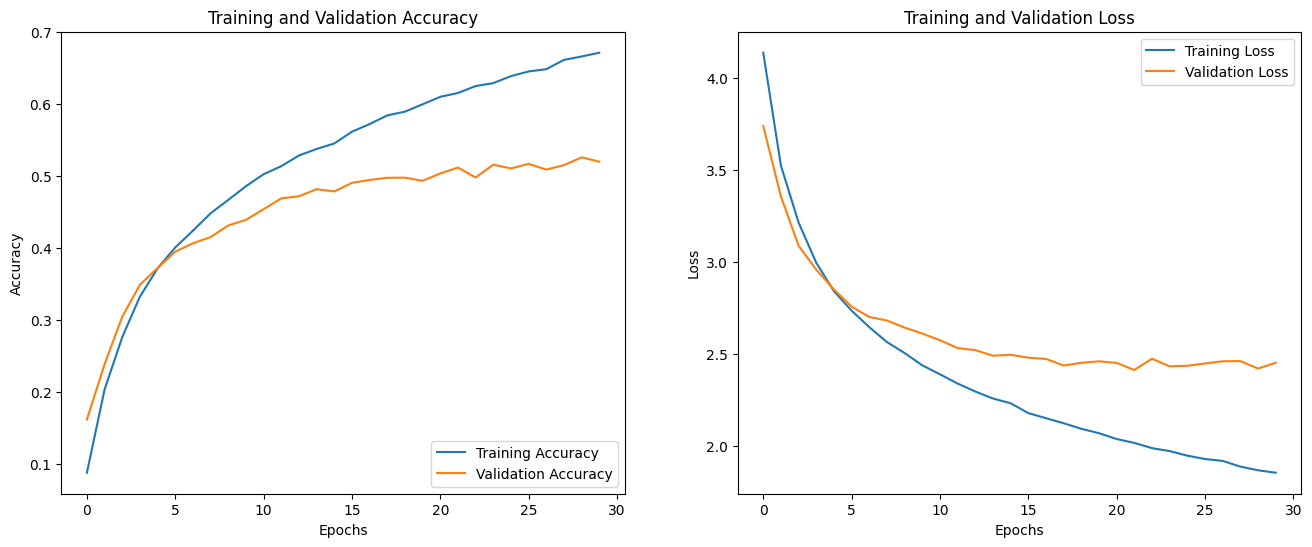

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plot training and validation accuracy per epoch
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [55]:
# Convert y_test back to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Predict the labels on the validation dataset
y_pred = cct_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test_classes, y_pred_classes, digits=4))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

           0     0.8111    0.7300    0.7684       100
           1     0.6628    0.5700    0.6129       100
           2     0.3819    0.5500    0.4508       100
           3     0.3113    0.3300    0.3204       100
           4     0.3462    0.2700    0.3034       100
           5     0.5323    0.3300    0.4074       100
           6     0.5366    0.6600    0.5919       100
           7     0.6296    0.5100    0.5635       100
           8     0.6542    0.7000    0.6763       100
           9     0.6974    0.5300    0.6023       100
          10     0.3605    0.3100    0.3333       100
          11     0.3978    0.3700    0.3834       100
          12     0.4911    0.5500    0.5189       100
          13     0.4815    0.3900    0.4309       100
          14     0.5833    0.4200    0.4884       100
          15     0.4031    0.5200    0.4541       100
          16     0.5476    0.4600    0.5

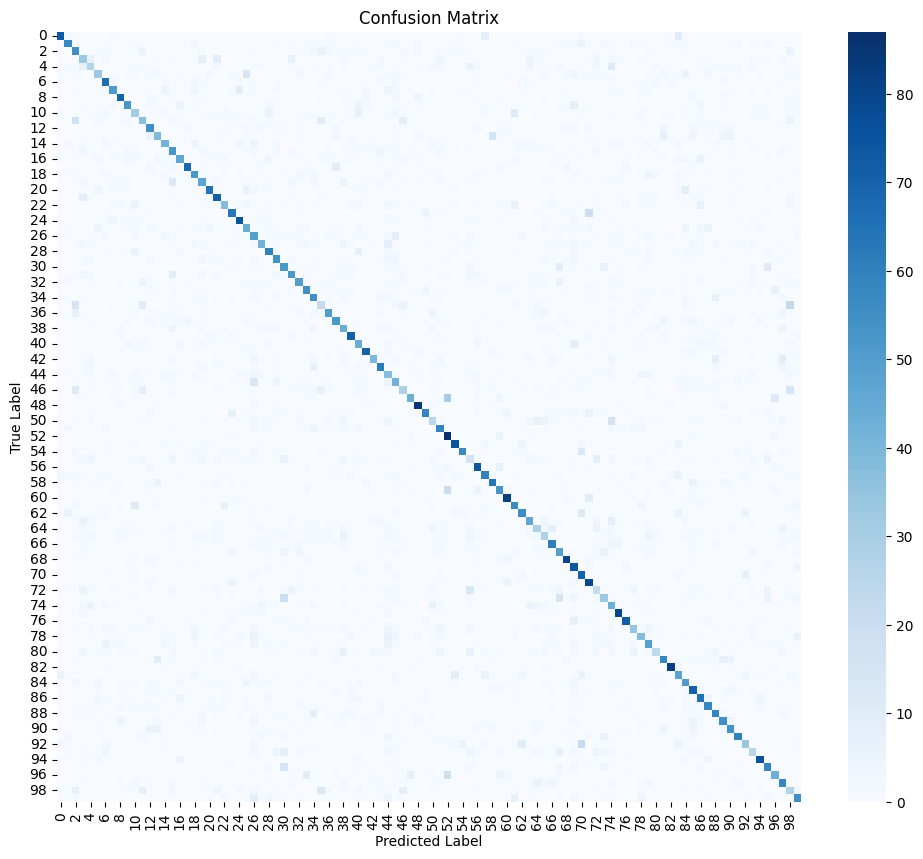

In [56]:

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mtx, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The CCT model we just trained has just **0.4 million** parameters, and it gets us to
~79% top-1 accuracy within 30 epochs. The plot above shows no signs of overfitting as
well. This means we can train this network for longer (perhaps with a bit more
regularization) and may obtain even better performance. This performance can further be
improved by additional recipes like cosine decay learning rate schedule, other data augmentation
techniques like [AutoAugment](https://arxiv.org/abs/1805.09501),
[MixUp](https://arxiv.org/abs/1710.09412) or
[Cutmix](https://arxiv.org/abs/1905.04899). With these modifications, the authors present
95.1% top-1 accuracy on the CIFAR-10 dataset. The authors also present a number of
experiments to study how the number of convolution blocks, Transformers layers, etc.
affect the final performance of CCTs.

For a comparison, a ViT model takes about **4.7 million** parameters and **100
epochs** of training to reach a top-1 accuracy of 78.22% on the CIFAR-10 dataset. You can
refer to
[this notebook](https://colab.research.google.com/gist/sayakpaul/1a80d9f582b044354a1a26c5cb3d69e5/image_classification_with_vision_transformer.ipynb)
to know about the experimental setup.

The authors also demonstrate the performance of Compact Convolutional Transformers on
NLP tasks and they report competitive results there.